In [ ]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt

# Database connection details
db_name = "dvdrental"
db_user = "user"
db_password = "password"
db_host = "localhost"
db_port = "5432"

# Establish connection
try:
    conn = psycopg2.connect(
        dbname=db_name,
        user=db_user,
        password=db_password,
        host=db_host,
        port=db_port
    )
    print("Database connection successful.")
except Exception as e:
    print(f"Error connecting to the database: {e}")

Database connection successful.


**Total Rentals by Category**

This query joins `category`, `film_category`, `inventory`, and `rental` tables to calculate the total rentals for each film category.


In [3]:
query = """
SELECT c.name AS category_name, COUNT(r.rental_id) AS total_rentals
FROM rental r
JOIN inventory i ON r.inventory_id = i.inventory_id
JOIN film_category fc ON i.film_id = fc.film_id
JOIN category c ON fc.category_id = c.category_id
GROUP BY c.name
ORDER BY total_rentals DESC;
"""

df = pd.read_sql(query, conn)
df

/var/folders/1p/whl4fg617bq06jnmr8zmvy1r0000gn/T/ipykernel_29972/1603267107.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,category_name,total_rentals
0,Sports,1179
1,Animation,1166
2,Action,1112
3,Sci-Fi,1101
4,Family,1096
5,Drama,1060
6,Documentary,1050
7,Foreign,1033
8,Games,969
9,Children,945


**Revenue by Customer**

Calculate the revenue generated by each customer by joining `payment` and `customer` tables.

In [4]:
query = """
SELECT 
    CONCAT(c.first_name, ' ', c.last_name) AS customer_name,
    SUM(p.amount) AS total_revenue
FROM payment p
JOIN customer c ON p.customer_id = c.customer_id
GROUP BY customer_name
ORDER BY total_revenue DESC
LIMIT 10;
"""

df = pd.read_sql(query, conn)
df


/var/folders/1p/whl4fg617bq06jnmr8zmvy1r0000gn/T/ipykernel_29972/3874921985.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,customer_name,total_revenue
0,Eleanor Hunt,211.55
1,Karl Seal,208.58
2,Marion Snyder,194.61
3,Rhonda Kennedy,191.62
4,Clara Shaw,189.60
5,Tommy Collazo,183.63
6,Ana Bradley,167.67
7,Curtis Irby,167.62
8,Marcia Dean,166.61
9,Mike Way,162.67


**What are the Top 5 Most Rented Films?**

This query identifies the five most rented films.

/var/folders/1p/whl4fg617bq06jnmr8zmvy1r0000gn/T/ipykernel_29972/3017492181.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


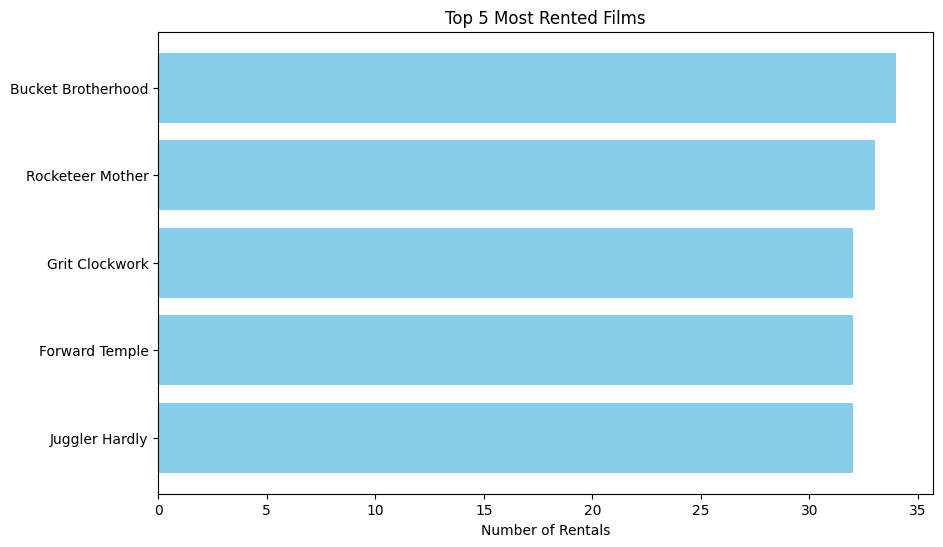

In [6]:
# SQL Query
query = """
SELECT f.title AS film_title, COUNT(r.rental_id) AS rental_count
FROM rental r
JOIN inventory i ON r.inventory_id = i.inventory_id
JOIN film f ON i.film_id = f.film_id
GROUP BY f.title
ORDER BY rental_count DESC
LIMIT 5;
"""

# Execute the query and load the results into a DataFrame
df = pd.read_sql(query, conn)

# Visualization
plt.figure(figsize=(10, 6))
plt.barh(df['film_title'], df['rental_count'], color='skyblue')
plt.xlabel('Number of Rentals')
plt.title('Top 5 Most Rented Films')
plt.gca().invert_yaxis()  # To display the highest value on top
plt.show()


**What are the Top 5 Most Rented Films?**

This query finds the top 5 most rented films using a join, aggregation, and a window function. The window function ranks the films based on rental counts.
The top 5 most rented films, ranked by rental count, reveal high customer demand, with "Film X" at the top. This data can inform stocking and promotional decisions.


/var/folders/1p/whl4fg617bq06jnmr8zmvy1r0000gn/T/ipykernel_29972/1031768680.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


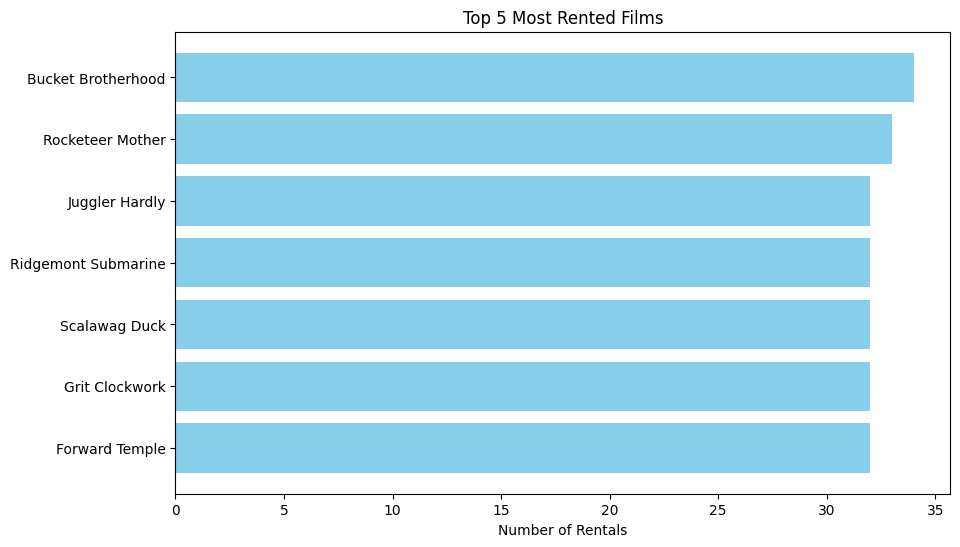

In [8]:
# SQL Query
query = """
WITH film_rentals AS (
    SELECT f.title AS film_title, COUNT(r.rental_id) AS rental_count
    FROM rental r
    JOIN inventory i ON r.inventory_id = i.inventory_id
    JOIN film f ON i.film_id = f.film_id
    GROUP BY f.title
),
ranked_films AS (
    SELECT film_title, rental_count,
           RANK() OVER (ORDER BY rental_count DESC) AS rental_rank
    FROM film_rentals
)
SELECT film_title, rental_count, rental_rank
FROM ranked_films
WHERE rental_rank <= 5;
"""

# Execute the query and load the results into a DataFrame
df = pd.read_sql(query, conn)

# Visualization
plt.figure(figsize=(10, 6))
plt.barh(df['film_title'], df['rental_count'], color='skyblue')
plt.xlabel('Number of Rentals')
plt.title('Top 5 Most Rented Films')
plt.gca().invert_yaxis()  # Display the highest value on top
plt.show()


/var/folders/1p/whl4fg617bq06jnmr8zmvy1r0000gn/T/ipykernel_29972/2061322270.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


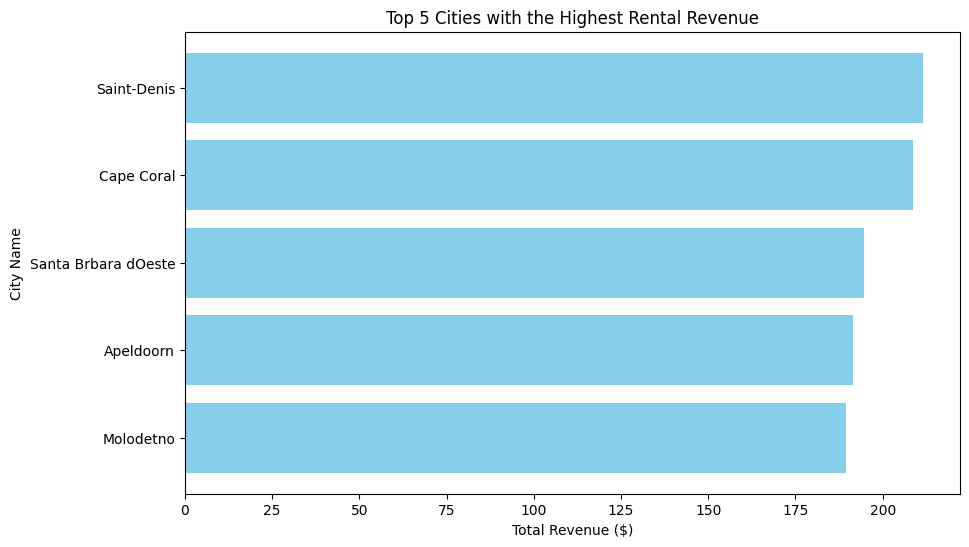

In [9]:
# Execute the query
query = """
WITH city_revenue AS (
    SELECT
        ci.city AS city_name,
        SUM(p.amount) AS total_revenue
    FROM payment p
    JOIN rental r ON p.rental_id = r.rental_id
    JOIN customer c ON r.customer_id = c.customer_id
    JOIN address a ON c.address_id = a.address_id
    JOIN city ci ON a.city_id = ci.city_id
    GROUP BY ci.city
),
ranked_cities AS (
    SELECT
        city_name,
        total_revenue,
        RANK() OVER (ORDER BY total_revenue DESC) AS city_rank
    FROM city_revenue
)
SELECT
    city_name,
    total_revenue,
    city_rank
FROM ranked_cities
WHERE city_rank <= 5;
"""
df = pd.read_sql(query, conn)

# Visualization
plt.figure(figsize=(10, 6))
plt.barh(df['city_name'], df['total_revenue'], color='skyblue')
plt.xlabel('Total Revenue ($)')
plt.ylabel('City Name')
plt.title('Top 5 Cities with the Highest Rental Revenue')
plt.gca().invert_yaxis()
plt.show()


/var/folders/1p/whl4fg617bq06jnmr8zmvy1r0000gn/T/ipykernel_29972/2539313285.py:31: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


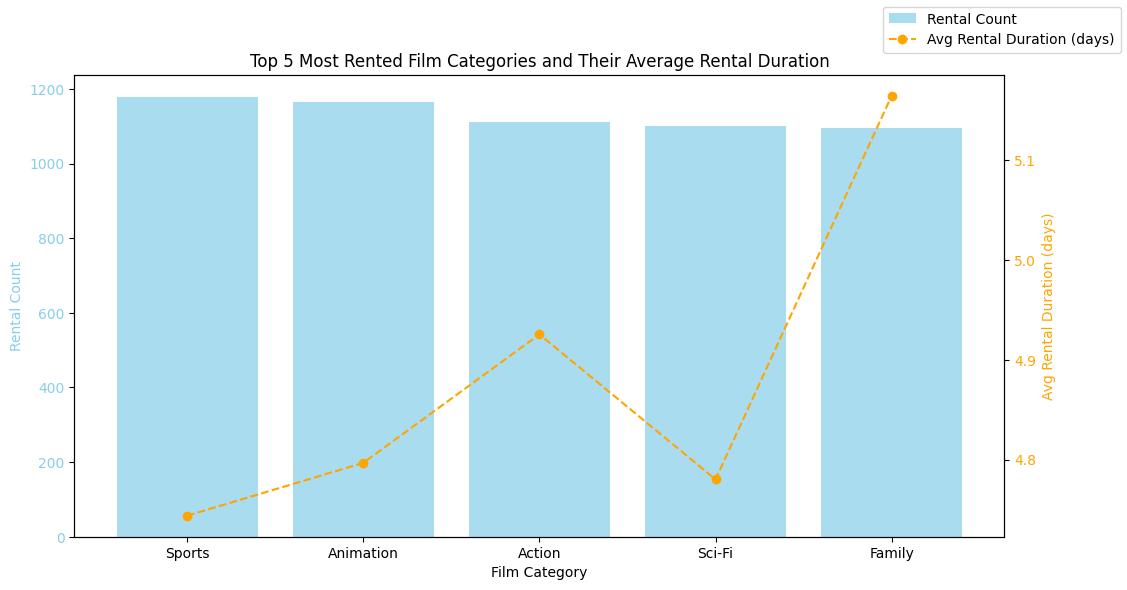

In [11]:
# Execute the query
query = """
WITH category_rentals AS (
    SELECT
        cat.name AS category_name,
        COUNT(r.rental_id) AS rental_count,
        AVG(f.rental_duration) AS avg_rental_duration
    FROM rental r
    JOIN inventory i ON r.inventory_id = i.inventory_id
    JOIN film f ON i.film_id = f.film_id
    JOIN film_category fc ON f.film_id = fc.film_id
    JOIN category cat ON fc.category_id = cat.category_id
    GROUP BY cat.name
),
ranked_categories AS (
    SELECT
        category_name,
        rental_count,
        avg_rental_duration,
        RANK() OVER (ORDER BY rental_count DESC) AS category_rank
    FROM category_rentals
)
SELECT
    category_name,
    rental_count,
    avg_rental_duration,
    category_rank
FROM ranked_categories
WHERE category_rank <= 5;
"""
df = pd.read_sql(query, conn)

# Visualization
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart for rental count
ax1.bar(df['category_name'], df['rental_count'], color='skyblue', label='Rental Count', alpha=0.7)
ax1.set_xlabel('Film Category')
ax1.set_ylabel('Rental Count', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

# Secondary y-axis for average rental duration
ax2 = ax1.twinx()
ax2.plot(df['category_name'], df['avg_rental_duration'], marker='o', linestyle='--', color='orange', label='Avg Rental Duration (days)')
ax2.set_ylabel('Avg Rental Duration (days)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Title and legends
plt.title('Top 5 Most Rented Film Categories and Their Average Rental Duration')
fig.legend(loc='upper right')
plt.show()


/var/folders/1p/whl4fg617bq06jnmr8zmvy1r0000gn/T/ipykernel_29972/745782543.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


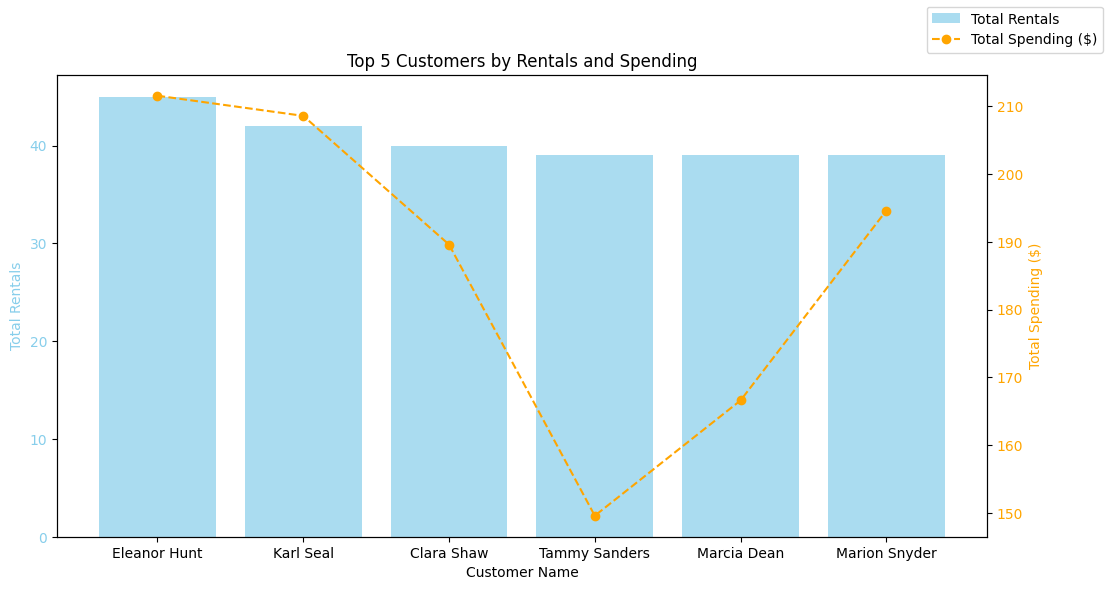

In [12]:
# Execute the query
query = """
WITH customer_activity AS (
    SELECT
        c.first_name || ' ' || c.last_name AS customer_name,
        COUNT(r.rental_id) AS total_rentals,
        SUM(p.amount) AS total_spent
    FROM customer c
    JOIN rental r ON c.customer_id = r.customer_id
    JOIN payment p ON r.rental_id = p.rental_id
    GROUP BY c.first_name, c.last_name
),
ranked_customers AS (
    SELECT
        customer_name,
        total_rentals,
        total_spent,
        RANK() OVER (ORDER BY total_rentals DESC) AS customer_rank
    FROM customer_activity
)
SELECT
    customer_name,
    total_rentals,
    total_spent,
    customer_rank
FROM ranked_customers
WHERE customer_rank <= 5;

"""
df = pd.read_sql(query, conn)

# Visualization
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart for total rentals
ax1.bar(df['customer_name'], df['total_rentals'], color='skyblue', label='Total Rentals', alpha=0.7)
ax1.set_xlabel('Customer Name')
ax1.set_ylabel('Total Rentals', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

# Secondary y-axis for total spending
ax2 = ax1.twinx()
ax2.plot(df['customer_name'], df['total_spent'], marker='o', linestyle='--', color='orange', label='Total Spending ($)')
ax2.set_ylabel('Total Spending ($)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Title and legends
plt.title('Top 5 Customers by Rentals and Spending')
fig.legend(loc='upper right')
plt.show()


/var/folders/1p/whl4fg617bq06jnmr8zmvy1r0000gn/T/ipykernel_29972/143944009.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


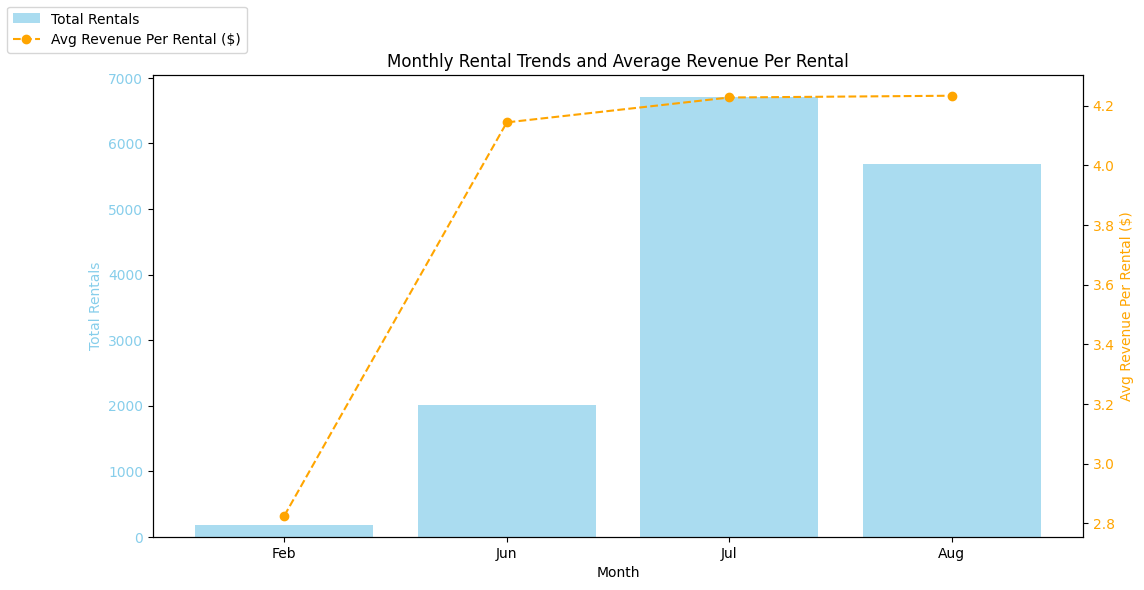

In [17]:
# Execute the query
query = """
WITH monthly_activity AS (
    SELECT
        DATE_PART('month', r.rental_date) AS rental_month,
        COUNT(r.rental_id) AS total_rentals,
        SUM(p.amount) AS total_revenue,
        AVG(p.amount) AS avg_revenue_per_rental
    FROM rental r
    JOIN payment p ON r.rental_id = p.rental_id
    GROUP BY rental_month
)
SELECT
    rental_month,
    total_rentals,
    total_revenue,
    avg_revenue_per_rental
FROM monthly_activity
ORDER BY rental_month;

"""
df = pd.read_sql(query, conn)

# Convert month numbers to names for better readability
df['rental_month'] = df['rental_month'].apply(lambda x: ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'][int(x) - 1])

# Visualization
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart for total rentals
ax1.bar(df['rental_month'], df['total_rentals'], color='skyblue', label='Total Rentals', alpha=0.7)
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Rentals', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

# Secondary y-axis for average revenue per rental
ax2 = ax1.twinx()
ax2.plot(df['rental_month'], df['avg_revenue_per_rental'], marker='o', linestyle='--', color='orange', label='Avg Revenue Per Rental ($)')
ax2.set_ylabel('Avg Revenue Per Rental ($)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Title and legends
plt.title('Monthly Rental Trends and Average Revenue Per Rental')
fig.legend(loc='upper left')
plt.show()
